## Required installs/imports


In [1]:
!pip install pure-prng

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.2 MB/s eta 0:00:00


In [11]:
# Necessary imports
#from pure_prng_package import pure_prng
import numpy as np
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import time

## Classes to provide data generation/evaluation methods

In [12]:
# Class used to access my implmentations of PRNGs
class PRNGManagement():
  # Initialises object and sets the default seed
  def __init__(self, seed=0):
      self.seed = seed
      self.random_number:int = seed
      self.currentGenerator = self.zero_only_PRNG()

  # Method to seed the PRNG (seeds all PRNGs in class)
  def seed_PRNG(self, seed:int):
    self.seed:int = seed
    self.random_number:int = seed

  def set_generator(self, generatorMethod):
    self.currentGenerator = generatorMethod

  def bit_success(self, model, inputData, trueOutputs, sequence_length):
    """ 
    Method to evaluate the provided model and store the amount of
    successful predictions for each bit of the output
    :param model: keras model - Model used to generate predicitions
    :param trueOutputs: list[list[int]]- List containing the expected y outputs
    :param sequence_length: int - Length of generated binary string being predicited
    :return list[int] - Amount of successful predictions for each bit
    """
    # Set initial amount of successful predictions for each bit to zero
    successfulPredicts = [0]*sequence_length
    # Feeds the input data to the model and stores the predictions made
    predicted = (model.predict(inputData).round())
    # Iterate over all outputed data
    for testIndex in range(0, len(inputData)):
      # Iterate over each bit in output
      for i in range(sequence_length):
        # If the predicted bit matches the true bit value then increment the successful predicts for the current bit
        if predicted[testIndex][i] == trueOutputs[testIndex][i]: successfulPredicts[i] += 1
        # Prediction may be greater than 1 if the prediction is made with high certainity
        elif predicted[testIndex][i] > 1 and trueOutputs[testIndex][i] == 1: self.successfulPredicts[i] += 1

    return successfulPredicts
   

  def zero_only_PRNG(self, length=100):
    """ 
    Returns a binary string containing only 0 of specified length.
    Used to test for major flaws in models
    :param length: int - Length of generated binary string
    :return string - generated binary string
    """
    return "0" * length        


  def alternating_bits_PRNG(self, length=100):
    """ 
    Returns output of a basic PRNG implementation that alernates each bit (010101)
    :param length: int - Length of generated binary string
    :return string - generated binary string
    """
    # Use seed to determine the starting bit of the generated binary string
    self.seed = self.seed%2
    # Utilises efficent method to repeat a string pattern
    if (self.seed == 1):
        output = "10" * int(length/2)
    else:
        output = "01" * int(length/2)

    # Length of generated binary string is odd
    if (length%2 == 1):
      # Add final bit to string
      output += str(self.seed)
      # Set the new seed value
      if (self.seed == 0): self.seed = 1
      else: self.seed = 0
    
    return output


  def alternating_num_PRNG(self):
    """ 
    Returns output of a basic PRNG implementation that alernates between two binary strings
    :return string - generated binary string
    """
    # Use seed to determine the binary string to be returned
    self.seed = (self.seed+1)%2
    if (self.seed == 0):
      # Convert integer to a binary string 
      randomBinary = str(bin(1643712566))[2:]
      # Returns binary string after ensuring a minimum length of 32
      return (32-len(randomBinary))*"0" + randomBinary
    else:
      # Convert integer to a binary string 
      randomBinary = str(bin(2372817037))[2:]
      # Returns binary string after ensuring a minimum length of 32
      return (32-len(randomBinary))*"0" + randomBinary


  def basic_equation_based(self, mult:int, add:int, mod:int, leng:int) -> str:
    """ 
    Returns output of a very weak equation based PRNG implementation
    Expected to be predicted near perfectly
    :return string - generated binary string
    """
    # Generates random number using previous output as seed
    self.random_number = (mult * self.random_number + add) % 2**mod
    # Converts generated number to a binary string
    bits_string = bin(self.random_number)[2:]
    # Returns binary string after using padding to ensure a length of 32
    return bits_string.zfill(leng)


  ## Different implmentations of equation based generators
  def basic_equation_based1(self) -> str:
    return self.basic_equation_based(20, 52, 32, 32)

  def basic_equation_based2(self) -> str:
    return self.basic_equation_based(36791, 83247, 32, 32)

  # Expects odd starting seed
  # Imeplementation of the PRNG 'RANDU' - Outdated PRNG
  def RANDU(self) -> str:
    return self.basic_equation_based(65539, 0, 31, 31)

  # Get stream of binary data form current generator
  def get_stream(self, number_of_blocks:int):
    stream = []
    for _ in range(number_of_blocks):
      # Converts generated binary string to list of ints
      block = [int(bit) for bit in self.currentGenerator()] 
      stream.extend(block)
    return stream

## Data generation function to be used during data production

In [13]:
# Creates object to use 'RANDU' PRNG
PRNGHandler = PRNGManagement(1)
PRNGHandler.set_generator(PRNGHandler.RANDU)

# Generation/seed functions for use
def generatorOutput(blockNum): return PRNGHandler.get_stream(blockNum)
def seedGenerator(seed): PRNGHandler.seed_PRNG(seed)

## Setting parameters for data generation

In [14]:
### Setting parameters
# Sets paramemters for generating train/test data
num_blocks = 10000
sequence_length = 31

# Calculates number of samples produced
num_samples = (num_blocks-1)*sequence_length

print("Number of samples: ", num_samples)

Number of samples:  309969


## Produces data for training/testing

In [15]:
# Seed generator
seedGenerator(23)
# Get stream data 
streamData = generatorOutput(num_blocks)

# Stores output in variable to allow the sample to be featued in both x and y data
X_data, Y_data = [], []

# Extracts stream data samples
for i in range(num_samples):
  X_data.append(streamData[i:i+sequence_length])
  Y_data.append([streamData[i+sequence_length]])

# Deletes variable to save memory
del streamData

## Splitting data into training/testing sets

In [16]:
### Separate data into training/testing sets
# Percentage of data used for testing the created prediction model
testDataPerc = 0.2

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = testDataPerc, random_state = 5)

# Deletes variable to save memory
del X_data
del Y_data

## Creation and training of different models

#### Dense + Normalisation + Dropout

In [17]:
# Sets parameters for model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.1))
  model.add(BatchNormalization())
  model.add(Dense(sequence_length//2, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 31)                992       
                                                                 
 batch_normalization_2 (Batc  (None, 31)               124       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 31)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 31)               124       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 15)                480       
                                                                 
 batch_normalization_4 (Batc  (None, 15)              

In [18]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2480/2480 [==============================] - 36s 13ms/step - loss: 0.6805 - accuracy: 0.5821 - val_loss: 0.5943 - val_accuracy: 0.6955
Epoch 2/10
2480/2480 [==============================] - 24s 10ms/step - loss: 0.5653 - accuracy: 0.7096 - val_loss: 0.5277 - val_accuracy: 0.7279
Epoch 3/10
2480/2480 [==============================] - 24s 10ms/step - loss: 0.5344 - accuracy: 0.7224 - val_loss: 0.5109 - val_accuracy: 0.7354
Epoch 4/10
2480/2480 [==============================] - 24s 9ms/step - loss: 0.5226 - accuracy: 0.7296 - val_loss: 0.5012 - val_accuracy: 0.7432
Epoch 5/10
2480/2480 [==============================] - 23s 9ms/step - loss: 0.5166 - accuracy: 0.7331 - val_loss: 0.4962 - val_accuracy: 0.7458
Epoch 6/10
2480/2480 [==============================] - 24s 9ms/step - loss: 0.5119 - accuracy: 0.7363 - val_loss: 0.4996 - val_accuracy: 0.7431
Epoch 7/10
2480/2480 [==============================] - 24s 9ms/step - loss: 0.5079 - accuracy: 0.7387 - val_loss: 0.4916 - val

In [19]:
model.save("RANDUDND1.h5")

#### Long Short-Term Memory

In [20]:
# Sets parameters for model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(LSTM(int(sequence_length), input_shape=(sequence_length, 1), return_sequences=True))
  model.add(LSTM(int(sequence_length/1.5), return_sequences=True))
  model.add(LSTM(int(sequence_length/2)))
  model.add(Dense(1, activation='sigmoid'))


  model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

  model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 31, 31)            4092      
                                                                 
 lstm_1 (LSTM)               (None, 31, 20)            4160      
                                                                 
 lstm_2 (LSTM)               (None, 15)                2160      
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 10,428
Trainable params: 10,428
Non-trainable params: 0
_________________________________________________________________


In [21]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2480/2480 [==============================] - 54s 18ms/step - loss: 0.6726 - accuracy: 0.5736 - val_loss: 0.6467 - val_accuracy: 0.6317
Epoch 2/10
2480/2480 [==============================] - 36s 14ms/step - loss: 0.6282 - accuracy: 0.6630 - val_loss: 0.6187 - val_accuracy: 0.6744
Epoch 3/10
2480/2480 [==============================] - 36s 15ms/step - loss: 0.6171 - accuracy: 0.6789 - val_loss: 0.6135 - val_accuracy: 0.6840
Epoch 4/10
2480/2480 [==============================] - 36s 15ms/step - loss: 0.6140 - accuracy: 0.6804 - val_loss: 0.6104 - val_accuracy: 0.6810
Epoch 5/10
2480/2480 [==============================] - 36s 15ms/step - loss: 0.6115 - accuracy: 0.6812 - val_loss: 0.6173 - val_accuracy: 0.6788
Epoch 6/10
2480/2480 [==============================] - 36s 15ms/step - loss: 0.6056 - accuracy: 0.6839 - val_loss: 0.6007 - val_accuracy: 0.6841
Epoch 7/10
2480/2480 [==============================] - 38s 15ms/step - loss: 0.5989 - accuracy: 0.6871 - val_loss: 0.5915 -

In [22]:
model.save("RANDULTSM1.h5")

#### Conv1d

In [23]:
# Sets parameters for produced model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length,1)))
  model.add(Flatten())
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 29, 128)           512       
                                                                 
 flatten_1 (Flatten)         (None, 3712)              0         
                                                                 
 dense_6 (Dense)             (None, 31)                115103    
                                                                 
 dense_7 (Dense)             (None, 1)                 32        
                                                                 
Total params: 115,647
Trainable params: 115,647
Non-trainable params: 0
_________________________________________________________________


In [24]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2480/2480 [==============================] - 26s 10ms/step - loss: 0.5795 - accuracy: 0.6862 - val_loss: 0.5412 - val_accuracy: 0.7228
Epoch 2/10
2480/2480 [==============================] - 16s 7ms/step - loss: 0.5255 - accuracy: 0.7290 - val_loss: 0.5155 - val_accuracy: 0.7310
Epoch 3/10
2480/2480 [==============================] - 16s 6ms/step - loss: 0.5079 - accuracy: 0.7385 - val_loss: 0.5048 - val_accuracy: 0.7395
Epoch 4/10
2480/2480 [==============================] - 15s 6ms/step - loss: 0.5006 - accuracy: 0.7428 - val_loss: 0.5001 - val_accuracy: 0.7424
Epoch 5/10
2480/2480 [==============================] - 16s 7ms/step - loss: 0.4971 - accuracy: 0.7453 - val_loss: 0.5002 - val_accuracy: 0.7436
Epoch 6/10
2480/2480 [==============================] - 17s 7ms/step - loss: 0.4943 - accuracy: 0.7471 - val_loss: 0.4970 - val_accuracy: 0.7441
Epoch 7/10
2480/2480 [==============================] - 17s 7ms/step - loss: 0.4924 - accuracy: 0.7486 - val_loss: 0.5027 - val_a

In [25]:
model.save("RANDUConv1D1.h5")

#### Conv1d + Normalisation + Dropout

In [26]:
# Sets parameters for produced model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length,1)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.1))
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 128)           512       
                                                                 
 flatten_2 (Flatten)         (None, 3712)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 3712)             14848     
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 3712)              0         
                                                                 
 dense_8 (Dense)             (None, 31)                115103    
                                                                 
 batch_normalization_6 (Batc  (None, 31)               124       
 hNormalization)                                      

In [27]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2480/2480 [==============================] - 32s 12ms/step - loss: 0.5728 - accuracy: 0.6984 - val_loss: 0.5195 - val_accuracy: 0.7297
Epoch 2/10
2480/2480 [==============================] - 21s 9ms/step - loss: 0.5171 - accuracy: 0.7349 - val_loss: 0.5021 - val_accuracy: 0.7429
Epoch 3/10
2480/2480 [==============================] - 22s 9ms/step - loss: 0.5048 - accuracy: 0.7420 - val_loss: 0.4948 - val_accuracy: 0.7466
Epoch 4/10
2480/2480 [==============================] - 22s 9ms/step - loss: 0.4988 - accuracy: 0.7460 - val_loss: 0.4926 - val_accuracy: 0.7479
Epoch 5/10
2480/2480 [==============================] - 22s 9ms/step - loss: 0.4949 - accuracy: 0.7478 - val_loss: 0.4867 - val_accuracy: 0.7524
Epoch 6/10
2480/2480 [==============================] - 21s 8ms/step - loss: 0.4918 - accuracy: 0.7507 - val_loss: 0.4851 - val_accuracy: 0.7516
Epoch 7/10
2480/2480 [==============================] - 20s 8ms/step - loss: 0.4897 - accuracy: 0.7523 - val_loss: 0.4844 - val_a

In [28]:
model.save("RANDUCND1.h5")

## Concatenated samples with best model

In [7]:
## Example for single model

# Sets paramemters for generating train/test data
num_blocks = 10000
sequence_length = 31
samplesConcatenated = 3
num_samples = (num_blocks-1)*sequence_length-sequence_length*(samplesConcatenated-1)

print("Number of samples: ", num_samples)

# Seed generator
seedGenerator(23)
# Get stream data 
streamData = generatorOutput(num_blocks)


# Stores output in variable to allow the sample to be featued in both x and y data
X_data = []
Y_data = []

for i in range(0, num_samples):
  X_data.append(streamData[i:i+sequence_length*samplesConcatenated])
  Y_data.append([streamData[i+sequence_length*samplesConcatenated]])

del streamData

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=32)
del X_data
del Y_data

Number of samples:  309907


In [8]:
# Sets parameters for produced model
epochs = 10

# Strategy to utilise GPU 
strategy = tf.distribute.OneDeviceStrategy('/gpu:0')

# Model compilation using GPU
with strategy.scope():
  model = Sequential()
  model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(sequence_length*samplesConcatenated,1)))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.1))
  model.add(Dense(sequence_length, input_shape=(sequence_length, ), activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 128)           512       
                                                                 
 flatten (Flatten)           (None, 11648)             0         
                                                                 
 batch_normalization (BatchN  (None, 11648)            46592     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 11648)             0         
                                                                 
 dense (Dense)               (None, 31)                361119    
                                                                 
 batch_normalization_1 (Batc  (None, 31)               124       
 hNormalization)                                        

In [9]:
batch_size = 100
# Train the model with the x/y train data and validate using the test data after each epoch
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2170/2170 [==============================] - 69s 26ms/step - loss: 0.5096 - accuracy: 0.7360 - val_loss: 0.3399 - val_accuracy: 0.8498
Epoch 2/10
2170/2170 [==============================] - 20s 9ms/step - loss: 0.2948 - accuracy: 0.8747 - val_loss: 0.2409 - val_accuracy: 0.9000
Epoch 3/10
2170/2170 [==============================] - 19s 9ms/step - loss: 0.2344 - accuracy: 0.9031 - val_loss: 0.1970 - val_accuracy: 0.9196
Epoch 4/10
2170/2170 [==============================] - 20s 9ms/step - loss: 0.2082 - accuracy: 0.9148 - val_loss: 0.1800 - val_accuracy: 0.9256
Epoch 5/10
2170/2170 [==============================] - 19s 9ms/step - loss: 0.1942 - accuracy: 0.9207 - val_loss: 0.1706 - val_accuracy: 0.9308
Epoch 6/10
2170/2170 [==============================] - 23s 10ms/step - loss: 0.1837 - accuracy: 0.9251 - val_loss: 0.1587 - val_accuracy: 0.9360
Epoch 7/10
2170/2170 [==============================] - 20s 9ms/step - loss: 0.1768 - accuracy: 0.9286 - val_loss: 0.1585 - val_

In [ ]:
model.save("RANDUCNDConcat1.h5")

#### Graphing current model history

Plotting graph


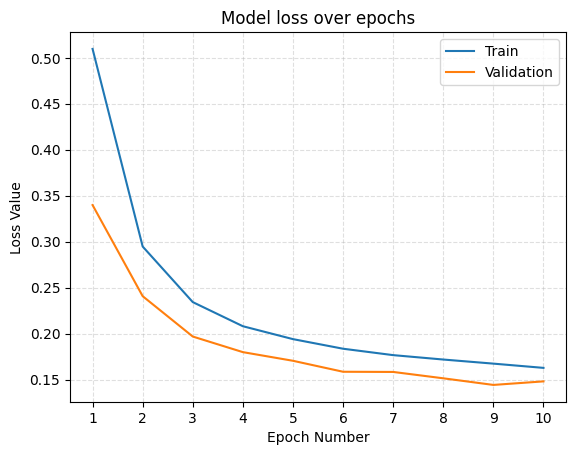

In [10]:
print("Plotting graph")
# Plot training & validation loss values
# Plots loss data
plt.plot(range(1, epochs+1), history.history['loss'])
plt.plot(range(1, epochs+1), history.history['val_loss'])
# Plots a label for each axis
plt.ylabel('Loss Value')
plt.xlabel('Epoch Number')
# Plots the title
plt.title('Model loss over epochs')
# Plots the legend for each loss
plt.legend(['Train', 'Validation'], loc='upper right')

# Sets grid for plot
plt.grid(linestyle='--', alpha=0.4)
# Ensures the x-axis only contains integers
plt.xticks(range(1, epochs+1))


# Displays plot
plt.show()